#Import Library

In [ ]:
!pip install category_encoders
!pip install tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.formula.api import ols
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import models, layers

In [ ]:
df = pd.read_csv('application_train.csv')

Y = df['TARGET']
X = df.drop(columns=['TARGET'])

X.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,157876,Cash loans,F,N,Y,0,67500.0,343800.0,16155.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,157878,Cash loans,M,Y,N,2,247500.0,945000.0,40167.0,945000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
2,157879,Revolving loans,M,N,Y,2,180000.0,540000.0,27000.0,540000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
3,157880,Cash loans,F,N,Y,0,112500.0,295168.5,16011.0,238500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
4,157881,Cash loans,F,N,Y,0,63000.0,298512.0,17266.5,270000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,157882,Cash loans,F,N,Y,0,67500.0,640080.0,24259.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
6,157883,Cash loans,F,N,N,0,157500.0,325908.0,17811.0,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
7,157884,Cash loans,M,N,Y,0,90000.0,545040.0,20677.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
8,157885,Cash loans,M,Y,N,0,112500.0,539959.5,42790.5,441000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
9,157887,Cash loans,F,N,Y,0,148500.0,1024740.0,52452.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0


#EDA

##Ukuran dataset

In [ ]:
print("Ukuran dataset:", df.shape)

##Info tipe data

In [ ]:
df.info()

##Statistik Numerik

In [ ]:
df.describe().T

##Distribusi Kelas Taget

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=Y)
plt.title("Distribusi Target")
plt.xlabel("TARGET")
plt.ylabel("Jumlah")
plt.show()

# Persentase kelas
Y.value_counts(normalize=True) * 100

# Pre-processing

## Missing Values

In [ ]:
# Penanganan Missing Values Numerik
kolom_angka = X.select_dtypes(include=['int64', 'float64']).columns
imputer_angka = SimpleImputer(strategy='median')
X[kolom_angka] = imputer_angka.fit_transform(X[kolom_angka])
joblib.dump(imputer_angka, "imputer_angka.pkl")

# Penanganan Missing Values Kata / Kategorik
kolom_kata = X.select_dtypes(include=['object']).columns
imputer_freq = SimpleImputer(strategy='most_frequent')
X[kolom_kata] = imputer_freq.fit_transform(X[kolom_kata])
joblib.dump(imputer_freq, "imputer_kategorikal.pkl")

['imputer_kategorikal.pkl']

In [ ]:
missing_df = df.isnull().sum()
missing_df = missing_df[missing_df > 0].reset_index()
missing_df.columns = ['kolom', 'jumlah_missing']
missing_df

,kolom,jumlah_missing
0,AMT_ANNUITY,11
1,AMT_GOODS_PRICE,240
2,NAME_TYPE_SUITE,1100
3,OWN_CAR_AGE,169979
4,OCCUPATION_TYPE,80737
...,...,...
61,AMT_REQ_CREDIT_BUREAU_DAY,34785
62,AMT_REQ_CREDIT_BUREAU_WEEK,34785
63,AMT_REQ_CREDIT_BUREAU_MON,34785
64,AMT_REQ_CREDIT_BUREAU_QRT,34785


## Encoding

In [ ]:
# Hubungan antara pekerjaan dengan gaji
model = ols('AMT_INCOME_TOTAL ~ C(OCCUPATION_TYPE)', data=X).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('Tabel ANOVA Pekerjaan dan Gaji:')
print(anova_table)

# Hubungan antara sektor kerja dengan gaji
model1 = ols('AMT_INCOME_TOTAL ~ C(ORGANIZATION_TYPE)', data=X).fit()
anova_table = sm.stats.anova_lm(model1, typ=2)
print('Tabel ANOVA Sektor Pekerjaan dan Gaji:')
print(anova_table)

# Hubungan antara pekerjaan dengan kredit diterima atau tidak
from scipy.stats import chi2_contingency
import pandas as pd

ct = pd.crosstab(X['OCCUPATION_TYPE'], Y)
chi2, p, dof, expected = chi2_contingency(ct)
print("Nilai p-value hubungan pekerjaan dengan gaji:", p)

# Hubungan antara sektor pekerjaan dengan kredit diterima atau tidak
ct1 = pd.crosstab(X['ORGANIZATION_TYPE'], Y)
chi21, p1, dof1, expected1 = chi2_contingency(ct1)
print("Nilai p-value hubungan sektor pekerjaan dengan gaji:", p1)

Tabel ANOVA Pekerjaan dan Gaji:
                          sum_sq        df            F  PR(>F)
C(OCCUPATION_TYPE)  2.012178e+14      17.0  1033.841212     0.0
Residual            2.948022e+15  257494.0          NaN     NaN
Tabel ANOVA Sektor Pekerjaan dan Gaji:
                            sum_sq        df           F  PR(>F)
C(ORGANIZATION_TYPE)  1.162516e+14      57.0  173.122283     0.0
Residual              3.032989e+15  257454.0         NaN     NaN
Nilai p-value hubungan pekerjaan dengan gaji: 2.2674253052234878e-205
Nilai p-value hubungan sektor pekerjaan dengan gaji: 1.5313484613894452e-258


In [ ]:
print('hasil encoding dengan OHE:')
X.head()

hasil encoding dengan OHE:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,157876.0,Cash loans,F,N,Y,0.0,67500.0,343800.0,16155.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,157878.0,Cash loans,M,Y,N,2.0,247500.0,945000.0,40167.0,945000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,157879.0,Revolving loans,M,N,Y,2.0,180000.0,540000.0,27000.0,540000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,157880.0,Cash loans,F,N,Y,0.0,112500.0,295168.5,16011.0,238500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,157881.0,Cash loans,F,N,Y,0.0,63000.0,298512.0,17266.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Encoding untuk kolom dengan One Hot Encoding
kolom_ohe = [
    "NAME_CONTRACT_TYPE",
    "HOUSETYPE_MODE",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "WEEKDAY_APPR_PROCESS_START",
    "FONDKAPREMONT_MODE",
    "WALLSMATERIAL_MODE",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "EMERGENCYSTATE_MODE",
    "CODE_GENDER"
]
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe_ganti = ohe.fit_transform(X[kolom_ohe])
ohe_df = pd.DataFrame(ohe_ganti,
                      columns=ohe.get_feature_names_out(kolom_ohe),
                      index=X.index)

X = pd.concat([X.drop(columns=kolom_ohe), ohe_df], axis=1)
joblib.dump(ohe, "ohe.pkl")

# Encoding untuk kolom dengan jenis kategori banyak
target_encode = TargetEncoder(cols=['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'])
X[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']] = target_encode.fit_transform(
    X[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']],
    Y)
joblib.dump(target_encode, "target_encoder.pkl")

['target_encoder.pkl']

In [ ]:
print('hasil encoding dengan Target Encoder:')
X[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']].head()

hasil encoding dengan Target Encoder:


,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,0.065321,0.064740
1,0.080097,0.053541
2,0.096504,0.093319
3,0.080097,0.086676
4,0.080097,0.053541


# Outlier

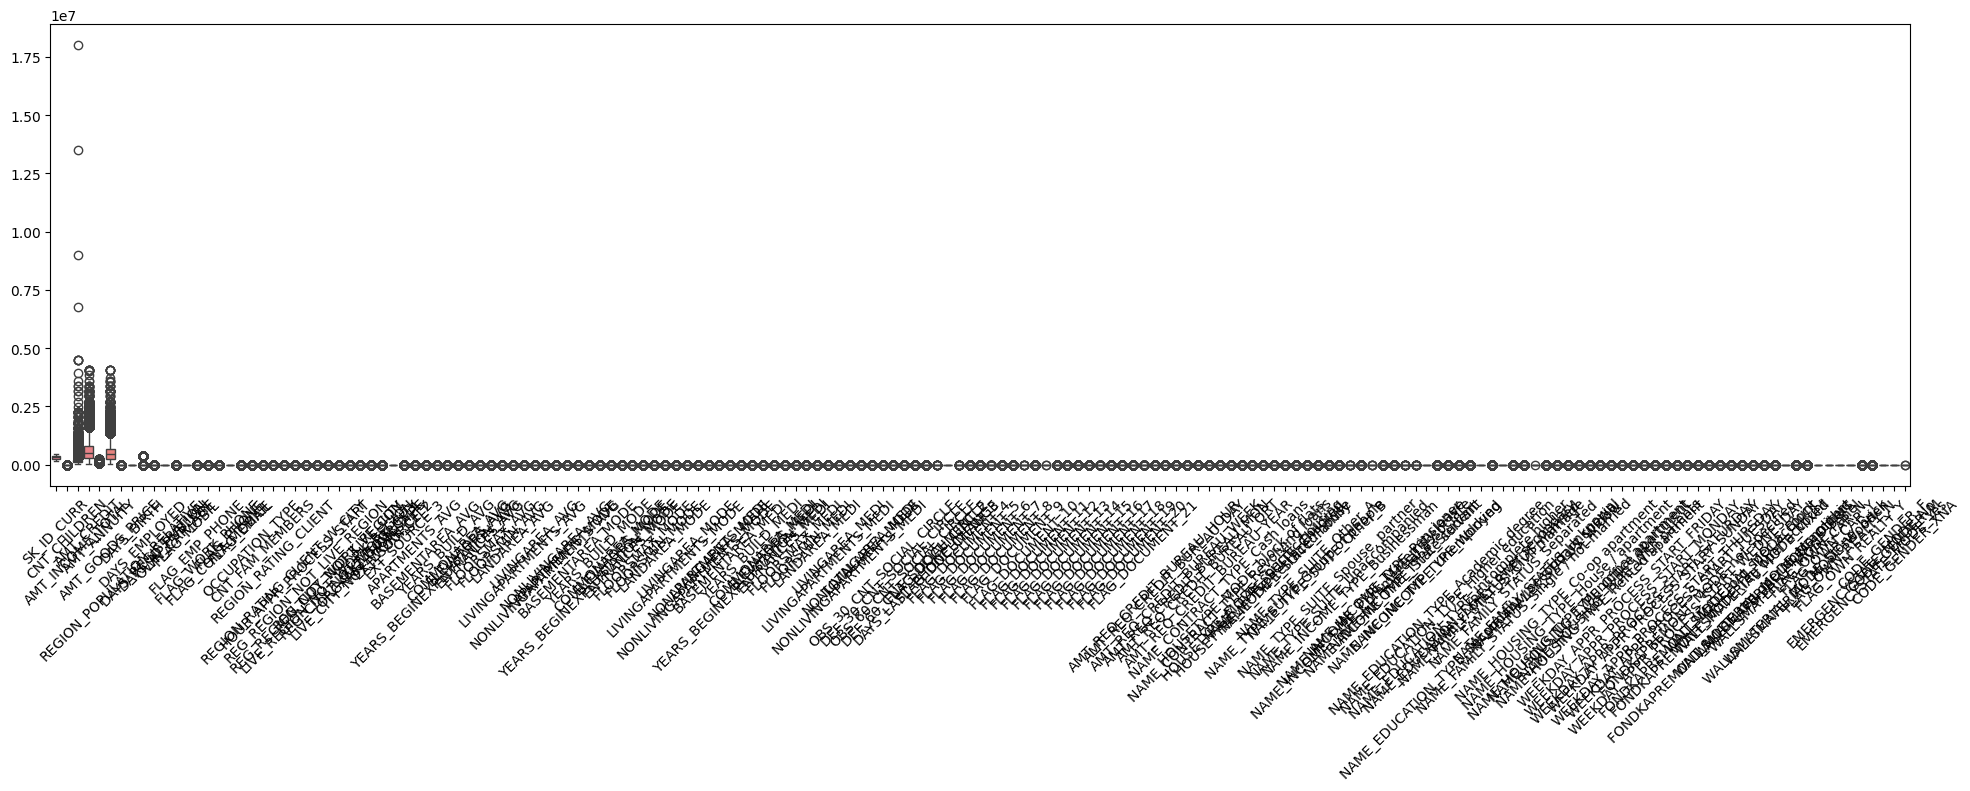

In [ ]:
# Cek data outlier dengan grafik
plt.figure(figsize=(24,6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.show()

Berdasarkan hasil grafik, ditemukan nilai yang sangat berbeda jauh di atas pada kolom 'AMT_INCOME_TOTAL yang merupakan kolom berisikan total gaji orang yang mengajukan kredit / pinjaman.

## Scaling Tanpa Penanganan Outlier

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

In [ ]:
# Mengambil data numerik saja
kolom_angka_scaling = X.select_dtypes(include=['float64', 'int64']).columns
joblib.dump(kolom_angka_scaling, "kolom_angka_scaling.pkl")

# Proses Scaling
scaler = StandardScaler()
X[kolom_angka_scaling] = scaler.fit_transform(X[kolom_angka_scaling])
joblib.dump(scaler, "scaler.pkl")

# Hasil Scaling
print('Hasil Scaling:')
print(X.head())
print('\nRata-rata hasil scaling:')
print(X.mean().round(2).head())
print('\nSimpangan baku hasil scaling:')
print(X.std().round(2).head())

Hasil Scaling:
   SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0   -1.734718     -0.577084         -0.912544   -0.633768    -0.756474   
1   -1.734695      2.193969          0.715134    0.859877     0.901818   
2   -1.734684      2.193969          0.104755   -0.146321    -0.007508   
3   -1.734672     -0.577084         -0.505624   -0.754590    -0.766419   
4   -1.734660     -0.577084         -0.953236   -0.746283    -0.679713   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        -0.848269                   -0.408862   -0.774685      -0.458069   
1         1.101868                   -0.128615    0.164486       2.131393   
2         0.004916                   -1.059931    1.127257      -0.452658   
3        -0.811704                    0.713137    0.965956      -0.483825   
4        -0.726385                   -0.206044   -1.388961       2.131393   

   DAYS_REGISTRATION  ...  WALLSMATERIAL_MODE_Wooden  FLAG_OWN_CAR_N  \
0    

#Split Data

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

## Balance-Imbalance

### Penanganan menggunakan SMOTE
SMOTE dipilih untuk menangani ketidakseimbangan kelas karena metode ini menyeimbangkan jumlah data dengan membuat sampel sintetis pada kelas minoritas, sehingga model dapat belajar pola dari kedua kelas dengan lebih adil dan meningkatkan performa prediksi untuk kelas minoritas.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Setelah SMOTE:", pd.Series(y_train_smote).value_counts())


Sebelum SMOTE: TARGET
0    189370
1     16639
Name: count, dtype: int64
Setelah SMOTE: TARGET
0    189370
1    189370
Name: count, dtype: int64


# Modeling

## Logistic Regression

In [ ]:
logistic_reg = LogisticRegression(
    max_iter=500,
    solver='lbfgs',
    random_state=42
)

logistic_reg.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=500, random_state=42)

Disini kelompok kami menggunakan solver 'lbfgs' karena merupakan algoritma optimisasi yang cepat dan stabil, cocok untuk dataset dengan jumlah fitur yang cukup banyak seperti dataset ini.

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_smote, y_train_smote)


RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=20,
                       n_estimators=300, n_jobs=-1, random_state=42)

## ANN

In [ ]:
ann_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    batch_size=256,
    max_iter=50,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42
)
ann_model.fit(X_train_smote, y_train_smote)

MLPClassifier(batch_size=256, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64), learning_rate='adaptive',
              max_iter=50, n_iter_no_change=5, random_state=42)

# Evaluasi Hasil Model

### Logistic Regression

EVALUASI LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     47343
           1       0.16      0.66      0.26      4160

    accuracy                           0.69     51503
   macro avg       0.56      0.68      0.53     51503
weighted avg       0.89      0.69      0.76     51503



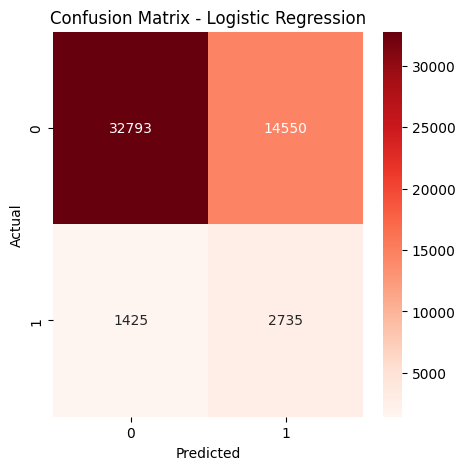

In [ ]:
pred_lr = logistic_reg.predict(X_valid)
print("EVALUASI LOGISTIC REGRESSION")
print(classification_report(y_valid, pred_lr))

cm_lr = confusion_matrix(y_valid, pred_lr)
plt.figure(figsize=(5,5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forest

EVALUASI RANDOM FOREST
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     47343
           1       0.23      0.13      0.16      4160

    accuracy                           0.89     51503
   macro avg       0.58      0.55      0.55     51503
weighted avg       0.87      0.89      0.88     51503



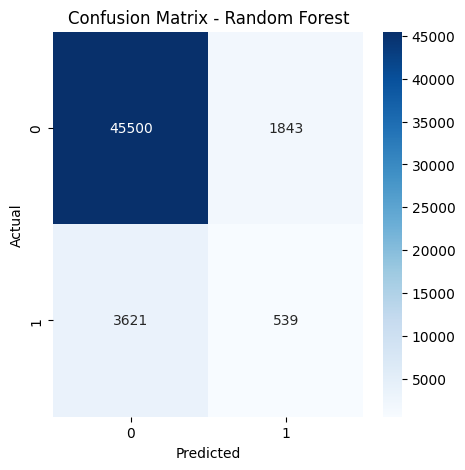

In [ ]:
pred_rf = rf_model.predict(X_valid)
print("EVALUASI RANDOM FOREST")
print(classification_report(y_valid, pred_rf))

cm_rf = confusion_matrix(y_valid, pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ANN

EVALUASI ANN
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     47343
           1       0.23      0.13      0.16      4160

    accuracy                           0.89     51503
   macro avg       0.58      0.55      0.55     51503
weighted avg       0.87      0.89      0.88     51503



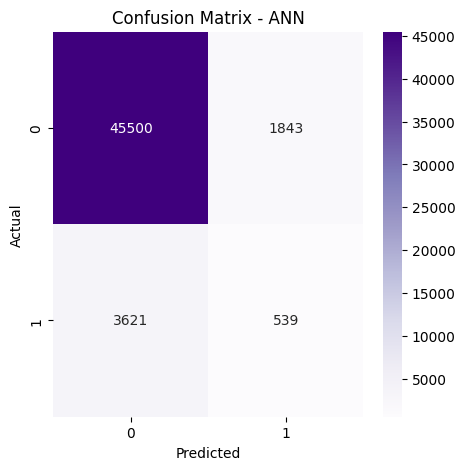

In [ ]:
pred_rf = rf_model.predict(X_valid)
print("EVALUASI ANN")
print(classification_report(y_valid, pred_rf))

cm_rf = confusion_matrix(y_valid, pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Testing

## Preprocessing Data Test

In [ ]:
df_test = pd.read_csv('application_test.csv')
df_test.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
miss_angka = joblib.load('imputer_angka.pkl')
miss_kategorik = joblib.load('imputer_kategorikal.pkl')

ohe_test = joblib.load('ohe.pkl')
target_test = joblib.load('target_encoder.pkl')

kolom_scaler = joblib.load('kolom_angka_scaling.pkl')
scaler_test = joblib.load('scaler.pkl')

## Missing Values

In [ ]:
# Penanganan Missing Values Numerik
kol_angka = df_test.select_dtypes(include=['int64', 'float64']).columns
df_test[kol_angka] = miss_angka.transform(df_test[kol_angka])

# Penanganan Missing Values Kata / Kategorik
kol_kata = df_test.select_dtypes(include=['object']).columns
df_test[kol_kata] = miss_kategorik.transform(df_test[kol_kata])

In [ ]:
missing_df = df_test.isnull().sum()
missing_df = missing_df[missing_df > 0].reset_index()
missing_df.columns = ['kolom', 'jumlah_missing']
missing_df

,kolom,jumlah_missing


## Encoding

In [ ]:
kolom_ohe_test = [
    "NAME_CONTRACT_TYPE", "HOUSETYPE_MODE", "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE",
    "WALLSMATERIAL_MODE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
    "EMERGENCYSTATE_MODE", "CODE_GENDER"
]
ohe_test_transform = ohe_test.transform(df_test[kolom_ohe_test])

ohe_df_test = pd.DataFrame(ohe_test_transform,
                           columns=ohe_test.get_feature_names_out(kolom_ohe_test),
                           index=df_test.index)

kolom_yang_ada = [col for col in kolom_ohe_test if col in df_test.columns]
df_test = df_test.drop(columns=kolom_yang_ada)
df_test = pd.concat([df_test, ohe_df_test], axis=1)

kolom_target_encd = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
df_test[kolom_target_encd] = target_test.transform(df_test[kolom_target_encd])

In [ ]:
df_test[['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']].head()

,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,0.080097,0.093319
1,0.064315,0.060191
2,0.080097,0.069291
3,0.080097,0.093319
4,0.064315,0.056486


## Scaling

In [ ]:
for col in kolom_scaler:
    if col not in df_test.columns:
         df_test[col] = 0

X_test_fix = df_test[kolom_scaler].copy()
X_test_scaled = scaler_test.transform(X_test_fix)

df_test[kolom_scaler] = X_test_scaled

## Model testing

In [ ]:
pred_test_lr = logistic_reg.predict(df_test)
print(pred_test_lr)

[1 0 0 ... 1 1 0]


In [ ]:
pred_test_rf = rf_model.predict(df_test)
print(pred_test_rf)

[1 0 0 ... 1 0 0]


In [ ]:
pred_test_ann = ann_model.predict(df_test)
print(pred_test_ann)

[0 0 0 ... 0 0 0]


## Masukkan kolom target pada data test

In [ ]:
df_test['TARGET_LR'] = pred_test_lr

/tmp/ipython-input-1645200753.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['TARGET_LR'] = pred_test_lr


In [ ]:
df_test['TARGET_RF'] = pred_test_rf

/tmp/ipython-input-2006224543.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['TARGET_RF'] = pred_test_rf


In [ ]:
df_test['TARGET_ANN'] = pred_test_ann

/tmp/ipython-input-4284358852.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['TARGET_ANN'] = pred_test_ann


In [ ]:
df_test[['TARGET_LR', 'TARGET_RF', 'TARGET_ANN']].head(10)

,TARGET_LR,TARGET_RF,TARGET_ANN
0,1,1,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,1,0,1
9,0,0,0


## Perbandingan antar model

In [ ]:
df_test[['TARGET_LR', 'TARGET_RF', 'TARGET_ANN']].sum()

,0
TARGET_LR,16979
TARGET_RF,1891
TARGET_ANN,3634


## Visualisasi

In [ ]:
import matplotlib.pyplot as plt

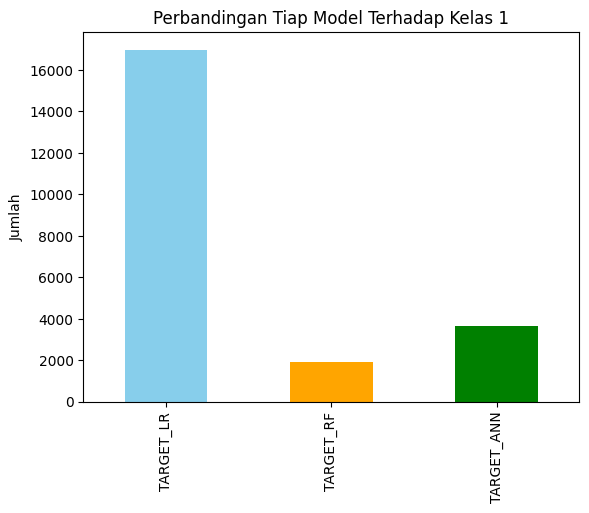

In [ ]:
counts = df_test[['TARGET_LR', 'TARGET_RF', 'TARGET_ANN']].sum()
counts.plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title('Perbandingan Tiap Model Terhadap Kelas 1')
plt.ylabel('Jumlah')
plt.show()